## Описание задания

Клиент (продуктовая сеть) хочет прогнозировать входящий трафик на месяц вперед с детализацией по часу. 

#### В ноутбуке

1. мини анализ данных
2. варианты, как сделать прогноз количества входящих
3. метрика для оценки качества
4. прогноз количество входящих на декабрь 2019 года 



#### Данные в архиве:
1. train.xlsx
2. test.xlsx


In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools
import numpy as np
import math
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [2]:
df_train=pd.read_excel('./train.xlsx')

In [3]:
df_test=pd.read_excel('./test.xlsx')

# Часть 1. Анализ данных.


In [4]:
df_train.shape

(15612, 10)

In [5]:
df_train.head()

,Unnamed: 0,Номер магазина,dt_h_open,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
0,831,Алтушка,2018-03-01 08:00:00,5,3,1,3,2018,8,0
1,11830,Бутово,2018-03-01 08:00:00,63,3,1,3,2018,8,0
2,832,Алтушка,2018-03-01 09:00:00,33,3,1,3,2018,9,0
3,11831,Бутово,2018-03-01 09:00:00,55,3,1,3,2018,9,0
4,833,Алтушка,2018-03-01 10:00:00,63,3,1,3,2018,10,0


### Разделелим датасет по номерам (названиям) магазинов.

In [6]:
df_train['Номер магазина'].value_counts()

Алтушка    9287
Бутово     6325
Name: Номер магазина, dtype: int64

In [7]:
df_train.isnull().sum()

Unnamed: 0                 0
Номер магазина             0
dt_h_open                  0
Количество вошедших        0
weekday                    0
day                        0
month                      0
year                       0
hour                       0
weekday_number_in_month    0
dtype: int64

In [8]:
df_alt=df_train[df_train['Номер магазина']=='Алтушка']
df_but=df_train[df_train['Номер магазина']=='Бутово']

### Проведем анализ данных по каждому магазину

### Цель анализа заключается в поиске закономерностей в рядах, в частности наличия сезонных / месячных/ квартальных трендов в данных 

In [9]:
df_alt= df_alt.set_index('dt_h_open')
df_but= df_but.set_index('dt_h_open')

In [10]:
y_alt = df_alt['Количество вошедших'].resample('W').mean()
y_but = df_but['Количество вошедших'].resample('W').mean()

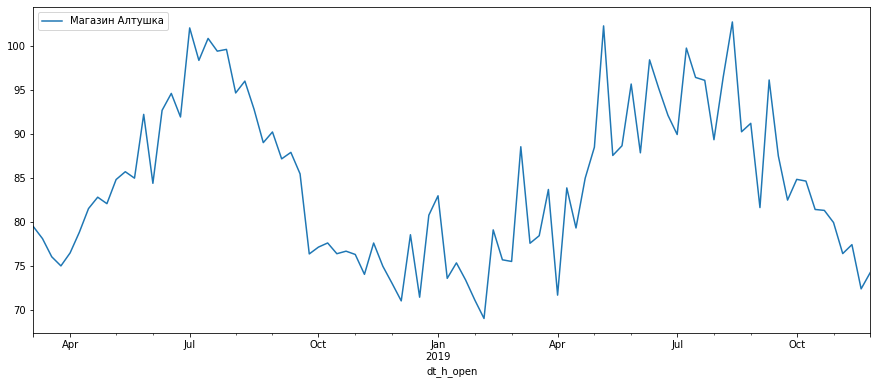

In [11]:
y_alt.plot(figsize=(15, 6),label='Магазин Алтушка')
plt.legend(loc="upper left")
plt.show()

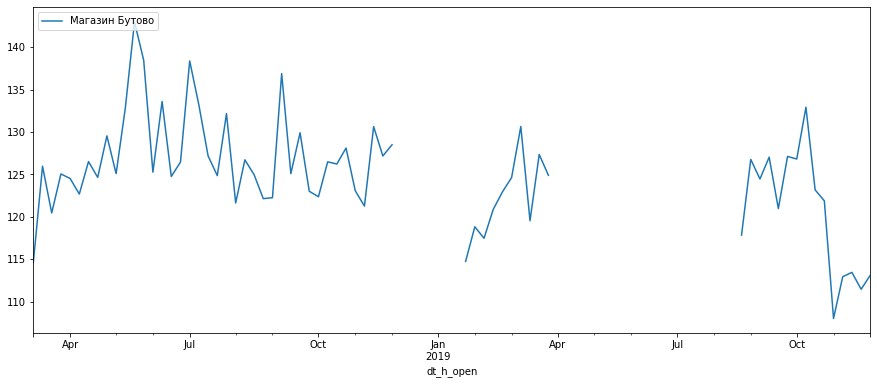

In [12]:
y_but.plot(figsize=(15, 6),label='Магазин Бутово')
plt.legend(loc="upper left")
plt.show()

### Видно, что в случае первого магазина, число посетителей летом гораздо больше, чем зимой. Во втором случае эта тенденция менее выражена, при этом данные неполны.

# Часть 2. Способы прогнозирования числа посетителей

### Попробуем восстановить недостающие данные во втором датасете путем заполнения пропусков значениями из того же распределения, что и начальные данные. Для этого вернемся к данным с дневной частотой.

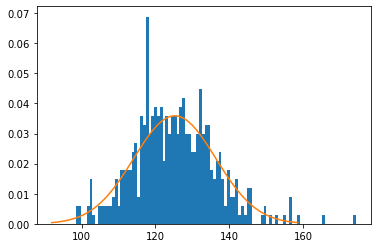

In [13]:
y_but_comp = df_but['Количество вошедших'].resample('D').mean()
mu=y_but_comp.mean()
sigma=y_but_comp.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(y_but_comp, bins=100, density=True)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

### Не учитывая выброс в районе x=100, получаем примерно нормальное распределение. Заполняем отстутсвующие значения рандомными значениями из этого же распределения. При этом, с учетом тенденции, на зимний период можно установить верхнюю границу, на летний - нижнюю.

In [14]:
minimum=min(y_but[4:18]) # минимум за тот же самый сезон прошлого года
maximum=130 # так как в истории нет данных за тот же сезон прошлого года, 
#выберем границу соотв. значению перед периодом отсутсвтия данных

### Определим интересующие нас интервалы и выполним заполнение.

In [15]:
#2018-12-01 - 2019-01-24
#2019-04-01 - 2019-08-24

In [16]:
df_but_com=pd.DataFrame(y_but_comp)

In [17]:
df_but_com.reset_index(level=0, inplace=True)

In [18]:
print(df_but_com[df_but_com['dt_h_open']=='2018-12-01'].index)
print(df_but_com[df_but_com['dt_h_open']=='2019-01-24'].index)
print(df_but_com[df_but_com['dt_h_open']=='2019-04-01'].index)
print(df_but_com[df_but_com['dt_h_open']=='2019-08-24'].index)

Int64Index([275], dtype='int64')
Int64Index([329], dtype='int64')
Int64Index([396], dtype='int64')
Int64Index([541], dtype='int64')


In [19]:
k=275
while k<=329:
    numb=np.random.normal(mu,sigma)
    if numb<maximum:
        y_but_comp[k]=numb
        k=k+1
    else:
        continue

In [20]:
k=396
while k<=541:
    numb=np.random.normal(mu,sigma)
    if numb>minimum:
        y_but_comp[k]=numb
        k=k+1
    else:
        continue

### Сведем частоту данных до одной недели и посмотрим на восстановленные данные.

In [21]:
y_but = y_but_comp.resample('W').mean()

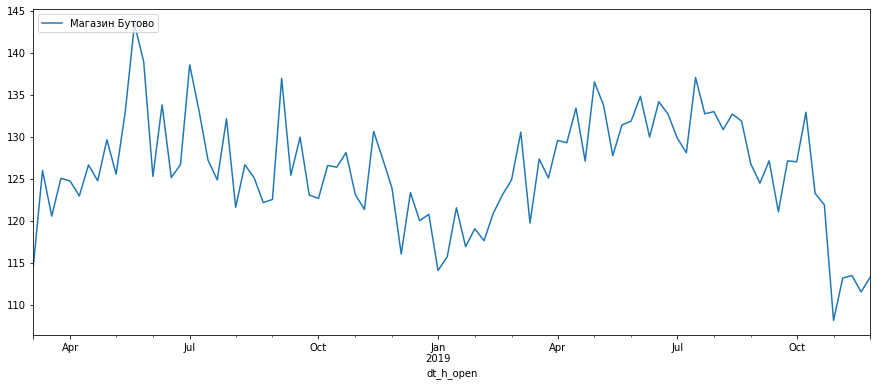

In [22]:
y_but.plot(figsize=(15, 6),label='Магазин Бутово')
plt.legend(loc="upper left")
plt.show()

### Прогнозировать число посетителей можно различными способами. Самый тривиальный и менее точный заключается в использовании сырых признаков для обучения модели (линейный регрессор, svm, XGBoost) и последующего предсказания. Более точный метод привлекает извленичения новых признаков из сигнала и в целом использования методов анализа временных рядов.
### Воспользуемся часто используемой в таких случаях моделью ARIMA.

In [23]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_alt,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_alt = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_but,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_but = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

### Для выбора модели в таких случаях применяется  AIC (информационный критерий Акаике). Выбираем модель, минимизирующую AIC:

In [25]:
mod = sm.tsa.statespace.SARIMAX(y_alt,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results_alt.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3097      0.245     -1.262      0.207      -0.791       0.171
ma.L1         -0.2212      0.217     -1.019      0.308      -0.647       0.204
ar.S.L12      -0.1627      0.191     -0.854      0.393      -0.536       0.211
ma.S.L12      -1.0000   2625.307     -0.000      1.000   -5146.508    5144.508
sigma2        26.1311   6.86e+04      0.000      1.000   -1.34e+05    1.34e+05


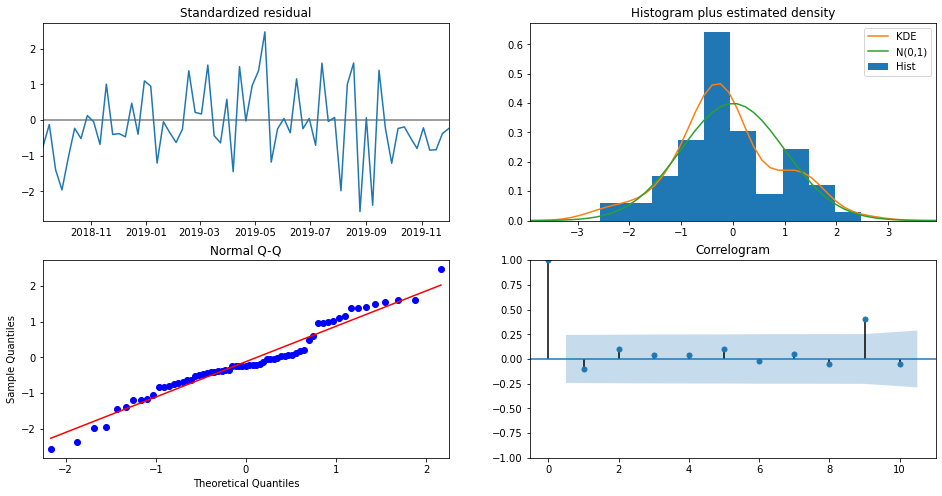

In [26]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [27]:
mod = sm.tsa.statespace.SARIMAX(y_but,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results_but.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1796      0.270     -0.666      0.505      -0.708       0.349
ma.L1         -0.4325      0.211     -2.050      0.040      -0.846      -0.019
ar.S.L12      -0.3799      0.139     -2.742      0.006      -0.651      -0.108
ma.S.L12      -0.4416      0.208     -2.120      0.034      -0.850      -0.033
sigma2        29.6531      4.923      6.023      0.000      20.004      39.302


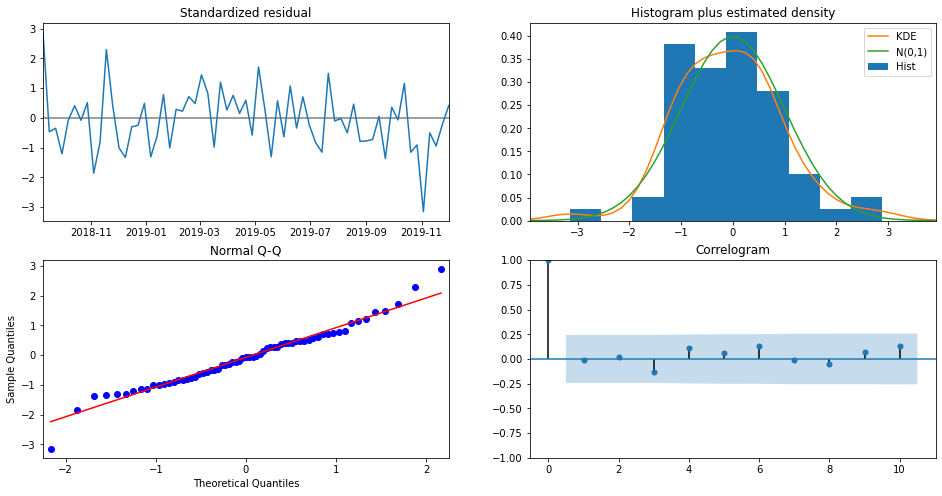

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Видно, что остатки распределены примерно по нормальному закону.

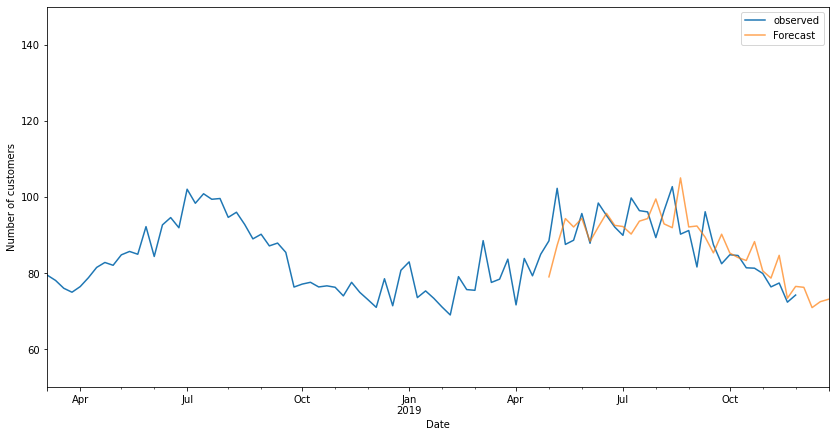

In [29]:
pred_alt = results_alt.get_prediction(start=pd.to_datetime('2019-5-05'),end=pd.to_datetime('2019-12-29'), dynamic=False)

pred_ci = pred_alt.conf_int()

ax = y_alt['2018':].plot(label='observed')
pred_alt.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))


ax.set_xlabel('Date')
ax.set_ylabel('Number of customers')
ax.set_ylim(50,150)
plt.legend()
plt.show()

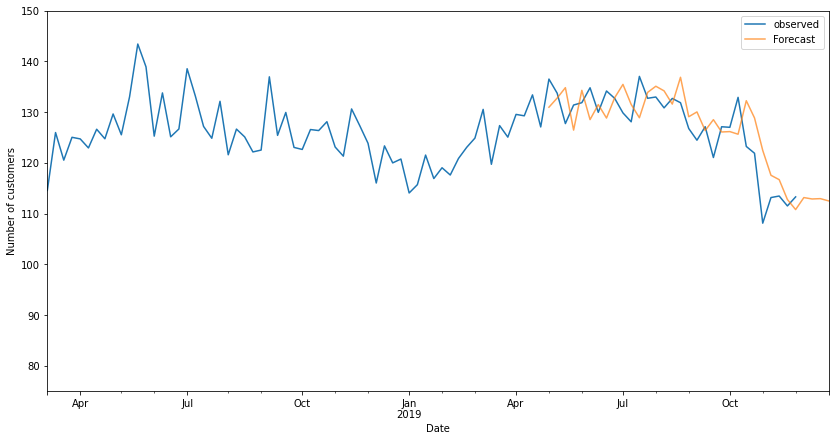

In [30]:
pred_but = results_but.get_prediction(start=pd.to_datetime('2019-5-05'),end=pd.to_datetime('2019-12-29'), dynamic=False)

pred_ci = pred_but.conf_int()

ax = y_but['2018':].plot(label='observed')
pred_but.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))


ax.set_xlabel('Date')
ax.set_ylabel('Number of customers')
ax.set_ylim(75,150)
plt.legend()
plt.show()

### Видно, что предсказание соответствует сезонному тренду в данных.

# Часть 3. Оценка полученных результатов.

### В данном случае, для оценки совпадения прогнозов может подойти одна из простейших метрик - RMSE. Ее значение в данном случае - погрешность в предсказании среднего недельного числа посетителей. 

In [31]:
y_forecasted_alt = pred_alt.predicted_mean
y_truth_alt = y_alt['2019-5-05':]
mse_alt = ((y_forecasted_alt - y_truth_alt) ** 2).mean()

y_forecasted_but = pred_but.predicted_mean
y_truth_but = y_but['2019-5-05':]
mse_but = ((y_forecasted_but - y_truth_but) ** 2).mean()

print('MSE_ALT= {}'.format(round(mse_alt, 2)))
print('MSE_BUT= {}'.format(round(mse_but, 2)))

MSE_ALT= 42.41
MSE_BUT= 27.61


In [32]:
print('RMSE_ALT= {}'.format(round(np.sqrt(mse_alt), 2)))
print('RMSE_BUT= {}'.format(round(np.sqrt(mse_but), 2)))

RMSE_ALT= 6.51
RMSE_BUT= 5.25


### Что являтся неплохим результатом.

# Часть 4. Предсказание для тестовых данных.

### В данном методе предсказания отдельные признаки не используются, предсказание на декабрь можно получить без test.

In [33]:
pred_alt.predicted_mean[30:]

2019-12-01    76.487672
2019-12-08    76.245514
2019-12-15    70.916415
2019-12-22    72.473425
2019-12-29    73.107989
Freq: W-SUN, dtype: float64

In [34]:
pred_but.predicted_mean[30:]

2019-12-01    110.795981
2019-12-08    113.163277
2019-12-15    112.886880
2019-12-22    112.955867
2019-12-29    112.513504
Freq: W-SUN, dtype: float64

In [35]:
save=pd.DataFrame({'Алтушка':pred_alt.predicted_mean[30:], 'Бутово':pred_but.predicted_mean[30:]})

In [36]:
save

,Алтушка,Бутово
2019-12-01,76.487672,110.795981
2019-12-08,76.245514,113.163277
2019-12-15,70.916415,112.886880
2019-12-22,72.473425,112.955867
2019-12-29,73.107989,112.513504


In [37]:
save.to_csv('prediction.csv')